In [1]:
import pandas as pd
import numpy as np
import matplotlib as mplib
import matplotlib.pyplot as plt

In [2]:
# Scikit-Learn provides many helper functions to download popular datasets. 
# MNIST is one of them. The following code fetches the MNIST dataset
# MNIST dataset, which is a set of 70,000 small images of digits handwritten 
# by high school students and employees of the US Census Bureau
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()  
#mnist.data
#mnist.target

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
#Let's store data and target variable
X = mnist.data
y = mnist.target
X.shape, y.shape    

((70000, 784), (70000,))

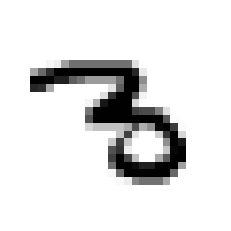

In [5]:
#Let's Just checkout a random digit
digit = X[30]
digit = digit.reshape(28, 28)

plt.imshow(digit, cmap = 'binary')
plt.axis('off')
plt.show()

In [4]:
#Now Let's confirm with label itself
print(y[30])
print(type(y[30]))
#Here we can see that type of the label is str, but here we need it as integer
#So let's cast it to Integer
y = y.astype(np.uint8)
print(type(y[30]))

3
<class 'str'>
<class 'numpy.uint8'>


In [5]:
# We don't need to use train test split for this dataset s
# The MNIST dataset is actually already split into a training set 
# (the first 60,000 images) and a test set (the last 10,000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
# For now let's simply the problem and will be working with binary classifier only
# Let's just say either 5 or not 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [48]:
#Let's Check out the data imabancity
sum(y_train_5)

#Here we can see the out of 60K values we only have 5421 values as 5 
#It mean's our data is highly imbalanced

5421

In [6]:
#for this experiment we will be using SGDClassifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 12)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=12, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
#Now When we have trained our model let's check the performance of the model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

print(accuracy_score(y_test_5, sgd_clf.predict(X_test)))
#Here we can see that our accuracy is over 94%, and that is quite great

0.9668


In [52]:
y_pred = sgd_clf.predict(X_test)

In [58]:
print("*******Confusion Matrix***************\n", confusion_matrix(y_test_5, y_pred))
#Let's Class 5 is Positive Class and Non-5 is negative Class
#Now we can notice one thing, recall of this model is less, but precision is good
#Now, Let's verify the above point
print("\nPrecision = ", precision_score(y_test_5, y_pred))
print("Recall = ", recall_score(y_test_5, y_pred))
print("F1-Score = ", f1_score(y_test_5, y_pred))
#Now From the below fact, we can discuss few things
#Like When we saw accuracy it was high, but now When we have seen F1 Score, we can say 
#Accuracy doesn't seem to be the right or promising choice as Performance Measure
#After Confusion Matrix, Lot of things are clearer like where our model is performing Bad
#Sometimes, we may want the higher precsion but doesn't care much about the Recall and
#In that case we will see later how we are gonna tune for increasing the precision or recall
#And when we care about both Precision and Recall we may wanna use F1-Score as Performance Measure

*******Confusion Matrix***************
 [[9046   62]
 [ 270  622]]

Precision =  0.9093567251461988
Recall =  0.6973094170403588
F1-Score =  0.7893401015228426


In [9]:
#Now Let's See How we can increase the Precision or Recall
#As of Now, the threshold for predicting 5 or Non-5 is 0.5
#But we can set it and check the affect on Precision and Recall
#SKlearn don't let change us the threhsold value directly but we can do it by a function
y_scores = sgd_clf.decision_function(X_test)
#By default SGD uses 0 as threshold, now let's verify this
#We are using 0 as threshold manually and default prediction values and see the result
print(accuracy_score(y_test_5, (y_scores>0)), accuracy_score(y_test_5, sgd_clf.predict(X_test)))
#And we can see that results are identical
#Now Let's Increase the Recall, we have to decrease the threshold for that
y_pred_ts = (y_scores>-1000)
print(accuracy_score(y_test_5, y_pred_ts))
print("\nPrecision = ", precision_score(y_test_5, y_pred_ts))
print("Recall = ", recall_score(y_test_5, y_pred_ts))
#Here we can clearly see the difference, Now Recall has been increased but the Precision has decreased
#and Now comes the Tradeoff between Precision and Recall, that totaly depends on the requirement
#If we want to increase the Precision we can increase the threshold

0.9668 0.9668
0.9685

Precision =  0.8358556461001164
Recall =  0.804932735426009


In [74]:
#Now Let's Plot the Precision and Recall curver for each threshold
#Just to select the best threshold 
from sklearn.metrics import precision_recall_curve
precisions, recals, thresholds = precision_recall_curve(y_test_5, y_scores)

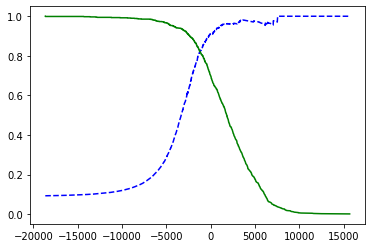

In [79]:
#Now Let's Print the Curve with the help of Matplotlib
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
plt.plot(thresholds, recals[:-1], "g-", label = 'Recall')
plt.show()

In [83]:
#Now Let's say you have decide to go with 80% Precision
#So Now all we have to do is find the threshold which gives 80% Precision
threshold_80 = thresholds[np.argmax(precisions >= 0.80)]
print(threshold_80)
print("\nPrecision = ", precision_score(y_test_5, (y_scores>-1437.75)))

-1437.7587254199257

Precision =  0.801063829787234


In [10]:
# ROC Curve
#ROC curve is the curve between TPR anf FPR
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_5, y_scores)

Text(0, 0.5, 'True Positive Rate')

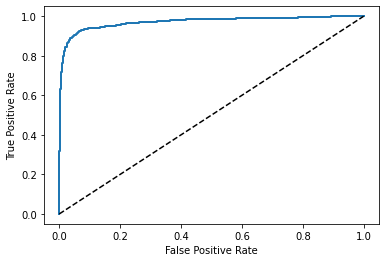

In [13]:
#We can plot the ROC curve and again there would be a tradeoff between TPR and FPR
#from the below Graph we can see that higher the TPR(Recall), higher the FPR
#A good model will be far away as much as possible from the dotted line towards the left-upper corner
#
plt.plot(fpr, tpr, linewidth=2, label='ROC')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [14]:
#While comparing the Models we can calculate the AUC(Area Under the curve)
#The Model with Higher AUC is good
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_5, y_scores)

0.9708728196371986